In [2]:
# 导入常用python库
import pandas as pd
import numpy as np
from tqdm import tqdm

# 用来读图片
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# 用来构建验证集
from sklearn.model_selection import train_test_split

# 用来验证模型性能
from sklearn.metrics import accuracy_score

# PyTorch 相关
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [3]:
# 加载数据集
train = pd.read_csv('emergency_vs_non-emergency_dataset/emergency_train.csv')
train.head()

image_names  emergency_or_not
0    1503.jpg                 0
1    1420.jpg                 0
2    1764.jpg                 0
3    1356.jpg                 0
4    1117.jpg                 0

In [4]:
# 加载用于训练的图片
train_img = []
for img_name in tqdm(train['image_names']):
    # 图片路径
    image_path = 'emergency_vs_non-emergency_dataset/images/' + img_name
    # 读图片
    img = imread(image_path)
    # 归一化[0,255]->[0,1]
    img = img/255
    # 把图片大小改为 (224,224,3), anti_aliasing：抗锯齿
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # 把图片矩阵数据类型改为float32
    img = img.astype('float32')
    # 把图片加到train_img列表
    train_img.append(img)

# 转换成numpy数组
train_x = np.array(train_img)
train_x.shape

100%|██████████| 1646/1646 [00:28<00:00, 56.94it/s]


(1646, 224, 224, 3)

It is an Emergency vehicle


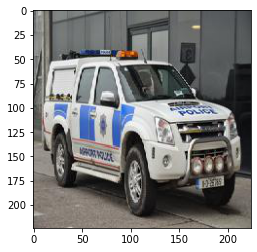

In [5]:
# 数据可视化
index = 10
plt.imshow(train_x[index])
if (train['emergency_or_not'][index] == 1):
    print('It is an Emergency vehicle')
else:
    print('It is a Non-Emergency vehicle')

In [6]:
# 要预测的目标: 1->救护车 0->非救护车
train_y = train['emergency_or_not'].values

In [7]:
# 构建验证集
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((1481, 224, 224, 3), (1481,)), ((165, 224, 224, 3), (165,)))

In [8]:
# 训练集Numpy格式改为PyTorch的输入格式：Tensor
train_x = train_x.reshape(1481, 3, 224, 224)
train_x  = torch.from_numpy(train_x)

train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

train_x.shape, train_y.shape

(torch.Size([1481, 3, 224, 224]), torch.Size([1481]))

In [9]:
# 验证集Numpy格式改为PyTorch的输入格式：Tensor
val_x = val_x.reshape(165, 3, 224, 224)
val_x  = torch.from_numpy(val_x)

val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

val_x.shape, val_y.shape

(torch.Size([165, 3, 224, 224]), torch.Size([165]))

In [10]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            #  CNN 调用方式：Conv2d(输入通道数，输出通道数....)
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            # BatchNormalization 调用方式：BatchNorm2d(输入通道数)
            BatchNorm2d(4),
            # ReLU激活函数，inplace=True代表原地计算，直接改变输入的值，不另分配内存，节约内存
            ReLU(inplace=True),
            # 最大池化
            MaxPool2d(kernel_size=2, stride=2),
            #第二个CNN
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        # 全连接层
        self.linear_layers = Sequential(
            Linear(8 * 56 * 56, 2)
        )

    # 前向传播
    def forward(self, x):
        # 把输入给cnn
        x = self.cnn_layers(x)
        # 把cnn的输出拉平，用来输入给全连接层
        x = x.view(x.size(0), -1)
        # 拉平给全连接层
        x = self.linear_layers(x)
        # 返回给全连接层
        return x

In [11]:
# 定义模型
model = Net()
# 优化器，使用Adam，优化的是model里面的全部参数
optimizer = Adam(model.parameters(), lr=0.0001)
# 定义损失函数为交叉熵
criterion = CrossEntropyLoss()
# 如果可以用GPU进行CUDA计算，就把模型权重放到GPU内存里
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=25088, out_features=2, bias=True)
  )
)


In [12]:
# 设置batch size大小
batch_size = 128
# 训练的epoch设置
n_epochs = 15

for epoch in range(1, n_epochs+1):
    # 记录训练的损失
    train_loss = 0.0
    # 随机索引
    permutation = torch.randperm(train_x.size()[0])
    #记录损失值
    training_loss = []
    for i in tqdm(range(0,train_x.size()[0], batch_size)):
        #随机选择一批样本
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = train_x[indices], train_y[indices]
        # 加载数据集
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        # 清空之前计算的梯度(如果有的话)，如果不清空，会一直累加
        optimizer.zero_grad()
        #前向传播，得到输出
        outputs = model(batch_x)
        # 计算损失值
        loss = criterion(outputs,batch_y)
        # 记录损失值
        training_loss.append(loss.item())
        # 反向传播，得到梯度
        loss.backward()
        # 根据算出来的梯度更新权重
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  0%|          | 0/12 [00:00<?, ?it/s]

epoch: 	 1 	 training loss: 	 0.8379034449656805


  8%|▊         | 1/12 [00:00<00:01, 10.00it/s]

epoch: 	 2 	 training loss: 	 0.6812309275070826


  0%|          | 0/12 [00:00<?, ?it/s]

epoch: 	 3 	 training loss: 	 0.6305637160936991


  8%|▊         | 1/12 [00:00<00:01,  9.97it/s]

epoch: 	 4 	 training loss: 	 0.6118684560060501


  8%|▊         | 1/12 [00:00<00:01,  9.94it/s]

epoch: 	 5 	 training loss: 	 0.5546631316343943


  0%|          | 0/12 [00:00<?, ?it/s]

epoch: 	 6 	 training loss: 	 0.53531364351511


  0%|          | 0/12 [00:00<?, ?it/s]

epoch: 	 7 	 training loss: 	 0.5195327003796896


  0%|          | 0/12 [00:00<?, ?it/s]

epoch: 	 8 	 training loss: 	 0.5150468796491623


  8%|▊         | 1/12 [00:00<00:01,  9.95it/s]

epoch: 	 9 	 training loss: 	 0.5009099841117859


  8%|▊         | 1/12 [00:00<00:01,  9.99it/s]

epoch: 	 10 	 training loss: 	 0.4766051893432935


  0%|          | 0/12 [00:00<?, ?it/s]

epoch: 	 11 	 training loss: 	 0.4620666379729907


  0%|          | 0/12 [00:00<?, ?it/s]

epoch: 	 12 	 training loss: 	 0.44733593612909317


  8%|▊         | 1/12 [00:00<00:01,  9.84it/s]

epoch: 	 13 	 training loss: 	 0.4180529440442721


  8%|▊         | 1/12 [00:00<00:01,  9.99it/s]

epoch: 	 14 	 training loss: 	 0.41642588128646213


100%|██████████| 12/12 [00:01<00:00,  7.47it/s]

epoch: 	 15 	 training loss: 	 0.39524493366479874


In [13]:
# 在训练集上做预测
prediction = []
target = []
permutation = torch.randperm(train_x.size()[0])
for i in tqdm(range(0,train_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = train_x[indices], train_y[indices]
    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
    with torch.no_grad():
        output = model(batch_x.cuda())
    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    # 选择概率最大的值
    predictions = np.argmax(prob, axis=1)
    # 预测值
    prediction.append(predictions)
    # 真实值
    target.append(batch_y)
    
# 计算训练集上的准确率
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 12/12 [00:00<00:00, 12.75it/s]

training accuracy: 	 0.8689622574200913


In [14]:
# 在验证集上做预测
prediction_val = []
target_val = []
permutation = torch.randperm(val_x.size()[0])
for i in tqdm(range(0,val_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = val_x[indices], val_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_val.append(predictions)
    target_val.append(batch_y)
    
# 验证集上的准确率
accuracy_val = []
for i in range(len(prediction_val)):
    accuracy_val.append(accuracy_score(target_val[i].cpu(),prediction_val[i]))
    
print('validation accuracy: \t', np.average(accuracy_val))

100%|██████████| 2/2 [00:00<00:00, 19.19it/s]

validation accuracy: 	 0.7089315878378378
